In [2]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

from utils.metrics import evaluate


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

netflix_expense = pd.read_csv('dataset/NetflixSpendByYear.csv', parse_dates=['Months in EXPDATE'])
netflix_expense.set_index('Months in EXPDATE', inplace=True)

Importing plotly failed. Interactive plots will not work.


2.5.0


In [3]:
netflix_expense

,Expense Amount USD,Forecast - Expense Amount USD
Months in EXPDATE,,
2016-01-01,202934.46,
2016-02-01,373884.44999999995,
2016-03-01,1517456.8500000003,
2016-04-01,883318.6900000002,
2016-05-01,712406.12,
...,...,...
2021-11-01,,2700945.1676394176
2021-12-01,,2738807.7311057155
2022-01-01,,2865486.5710113663


In [16]:
netflix_expense = netflix_expense.rename({' Expense Amount USD': 'X', ' Forecast - Expense Amount USD': 'Y'}, axis=1) 
for i in range(len(netflix_expense.X)):
    if netflix_expense.X[i] == ' ':
        print('yes')
        netflix_expense.X[i] = netflix_expense.Y[i]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [17]:
netflix_expense

,X,Y
Months in EXPDATE,,
2016-01-01,202934.46,
2016-02-01,373884.44999999995,
2016-03-01,1517456.8500000003,
2016-04-01,883318.6900000002,
2016-05-01,712406.12,
...,...,...
2021-11-01,2700945.1676394176,2700945.1676394176
2021-12-01,2738807.7311057155,2738807.7311057155
2022-01-01,2865486.5710113663,2865486.5710113663


In [82]:
# We split our dataset to be able to evaluate our models


resultsDict = {}
predictionsDict = {}

split_date = '2021-12-01'
split_date2= '2021-03-01'
df_training = netflix_expense.loc[netflix_expense.index < split_date2]
df_test = netflix_expense.loc[netflix_expense.index >= split_date2 ]
df_test = df_test.loc[df_test.index < split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")


df_training.to_csv('dataset2/training.csv')
df_test.to_csv('dataset2/test.csv')

62 days of training data 
 9 days of testing data 


## Simple Exponential Smoothing (SES)

In [21]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.X.astype(float))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    print('hey', yhat)

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['SES'] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 87.81it/s]

hey [2021-03-01    1.968831e+06
Freq: MS, dtype: float64]
hey [2021-03-01    1.968831e+06
Freq: MS, dtype: float64, 2021-04-01    1.418208e+06
Freq: MS, dtype: float64]
hey [2021-03-01    1.968831e+06
Freq: MS, dtype: float64, 2021-04-01    1.418208e+06
Freq: MS, dtype: float64, 2021-05-01    1.767674e+06
Freq: MS, dtype: float64]
hey [2021-03-01    1.968831e+06
Freq: MS, dtype: float64, 2021-04-01    1.418208e+06
Freq: MS, dtype: float64, 2021-05-01    1.767674e+06
Freq: MS, dtype: float64, 2021-06-01    1.950931e+06
Freq: MS, dtype: float64]
hey [2021-03-01    1.968831e+06
Freq: MS, dtype: float64, 2021-04-01    1.418208e+06
Freq: MS, dtype: float64, 2021-05-01    1.767674e+06
Freq: MS, dtype: float64, 2021-06-01    1.950931e+06
Freq: MS, dtype: float64, 2021-07-01    2.115755e+06
Freq: MS, dtype: float64]
hey [2021-03-01    1.968831e+06
Freq: MS, dtype: float64, 2021-04-01    1.418208e+06
Freq: MS, dtype: float64, 2021-05-01    1.767674e+06
Freq: MS, dtype: float64, 2021-06-01    1.

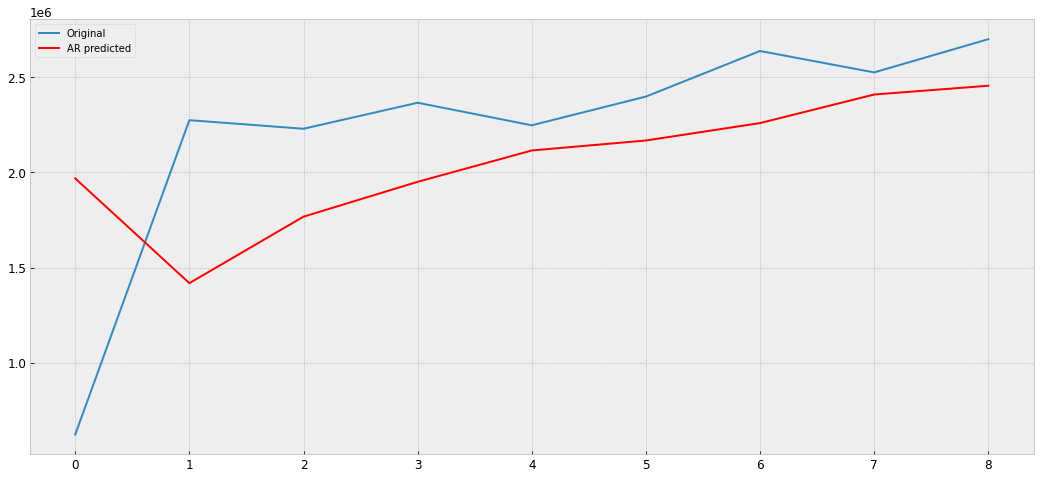

In [22]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

## Holt Winter’s Exponential Smoothing (HWES)

In [23]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.X.astype(float))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['HWES'] = yhat.values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 127.10it/s]


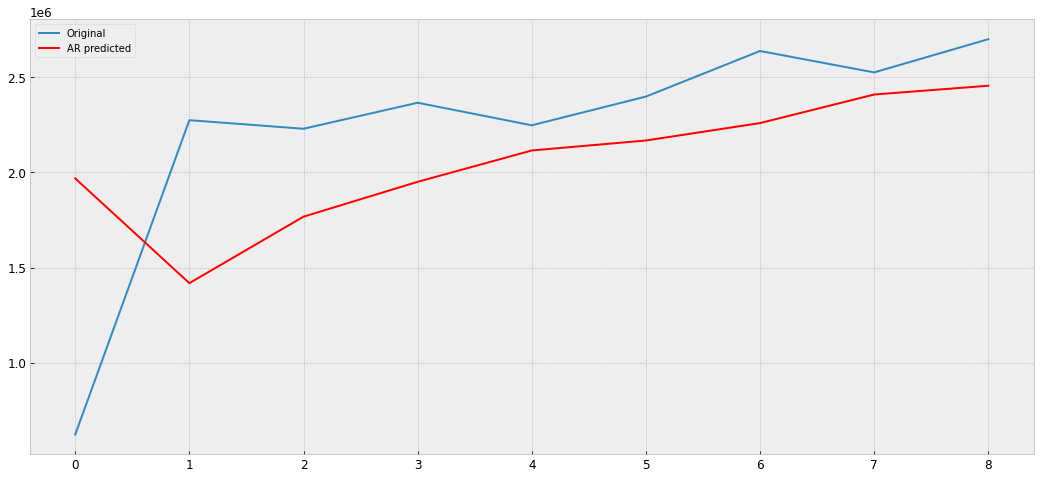

In [24]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

## Autoregression (AR)

In [25]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = AR(temp_train.X.astype(float))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['AR'] = yhat.values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.75it/s]


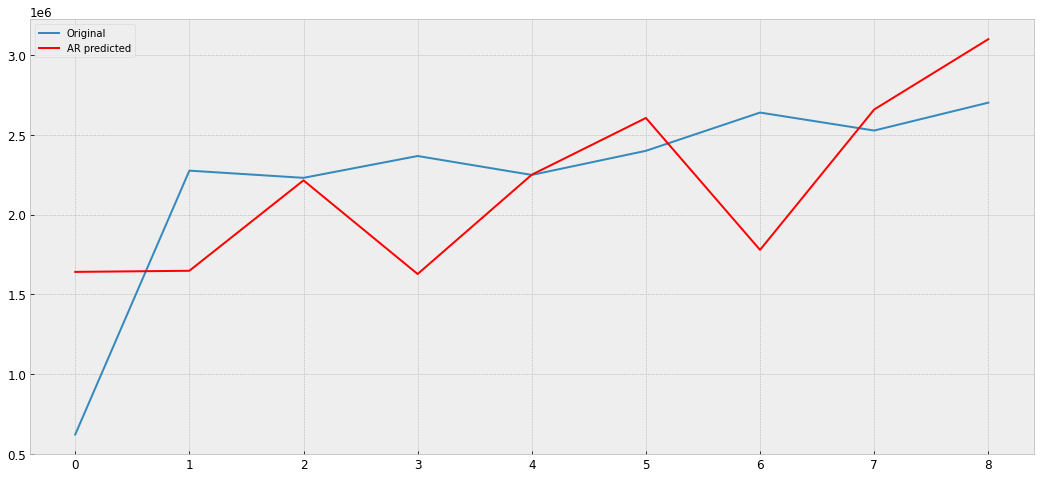

In [26]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

## Moving Average

In [27]:
# MA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARMA(temp_train.X.astype(float), order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['MA'] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 43.35it/s]


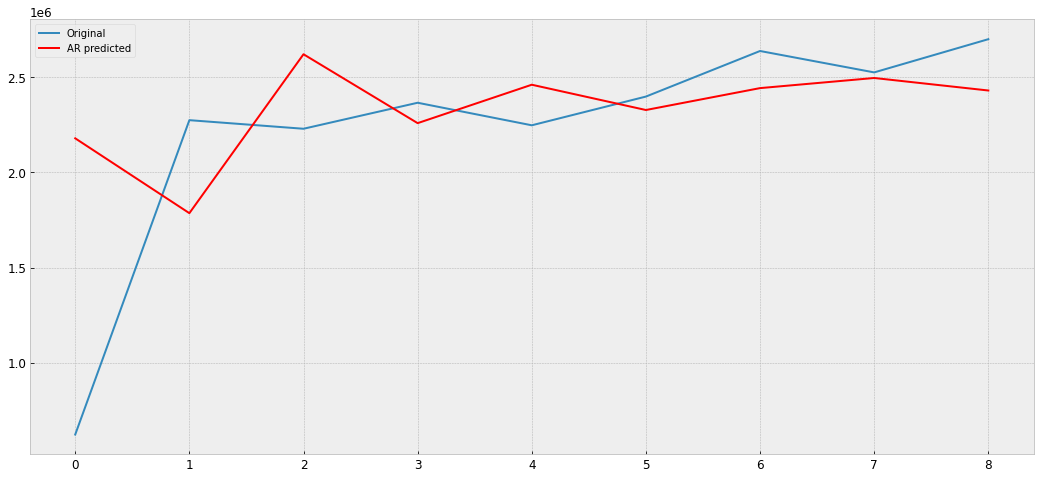

In [28]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

# Autoregressive Moving Average (ARMA)

In [29]:
# ARMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARMA(temp_train.X.astype(float), order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.79it/s]


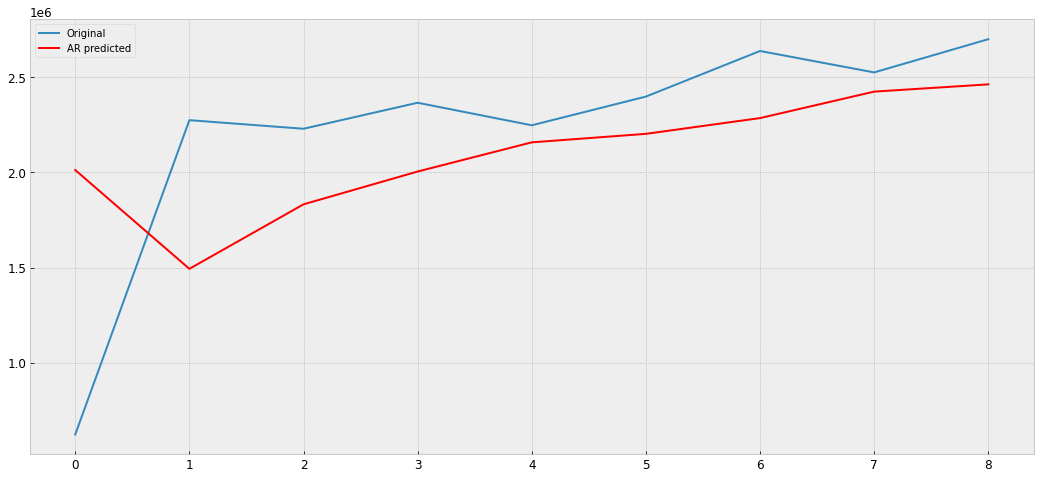

In [30]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

# Autoregressive integrated moving average (ARIMA)

In [83]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARIMA(temp_train.X.astype(float), order=(1, 0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 29.97it/s]


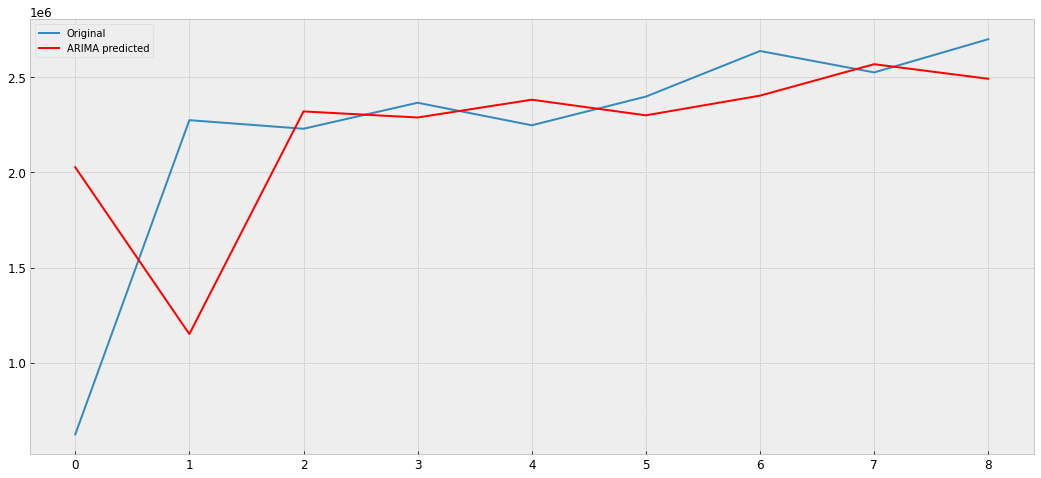

In [84]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

In [33]:
#Auto Arima

autoModel = pm.auto_arima(df_training.X.astype(float), trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.X.astype(float))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1837.866, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1856.715, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1835.389, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1834.393, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1854.771, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1834.092, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1836.056, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1835.906, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1834.361, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1835.270, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1832.498, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1832.697, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1833.619, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1834.465, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [34]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = ARIMA(temp_train.X.astype(float), order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.X.astype(float), yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 28.50it/s]


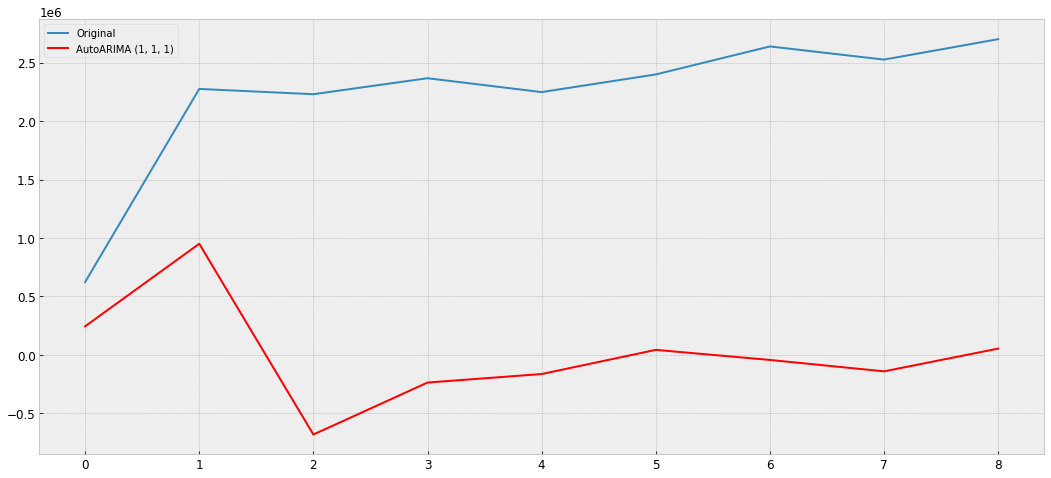

In [35]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

# SARIMA

In [36]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = SARIMAX(temp_train.X.astype(float), order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.X.astype(float), yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 52.15it/s]


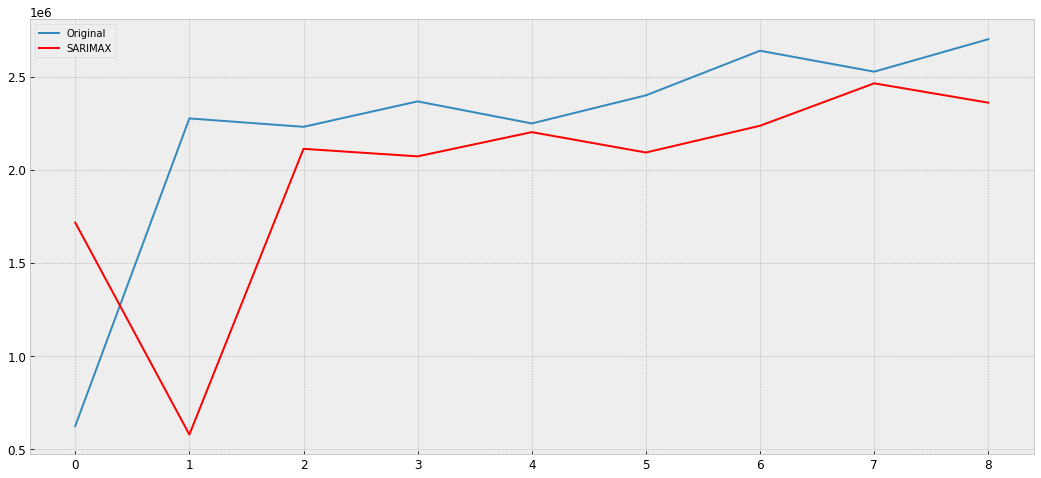

In [37]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

In [38]:
#AUTO SARIMA

autoModel = pm.auto_arima(df_training.X.astype(float), trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.X.astype(float))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=1839.400, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1856.715, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=1834.774, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=1834.513, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1854.771, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=1834.393, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=1834.801, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=1836.396, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=1834.092, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[6] intercept   : AIC=1833.929, Time=0.03 sec
 ARIMA(1,1,1)(2,0,0)[6] intercept   : AIC=1835.825, Time=0.05 sec
 ARIMA(1,1,1)(1,0,1)[6] intercept   : AIC=1835.535, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=1833.730, Time=0.03 sec
 ARIMA(1,1,1)(0,0,2)[6] intercept   : AIC=1835.608, Time=0.05 sec
 ARIMA(1,1,1)(1,0,2)[6] intercept

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 6),
      suppress_warnings=True, with_intercept=False)

In [39]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.X))):
    temp_train = netflix_expense[:len(df_training)+t]
    model = SARIMAX(temp_train.X.astype(float), order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test.X.astype(float), yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 29.75it/s]


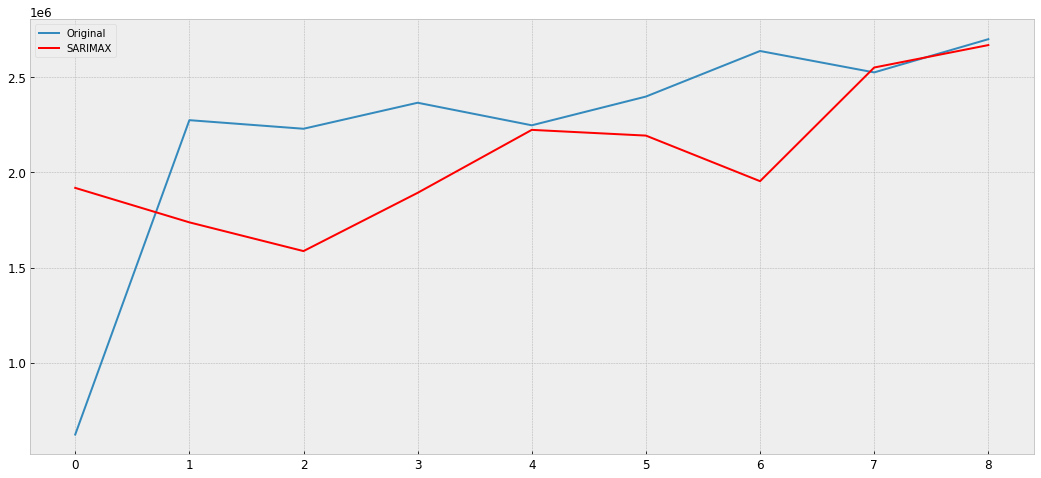

In [40]:
plt.plot(df_test.X.values.astype(float), label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()